Step 0: Installing libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.5 MB/s eta 0:00:00
KDDTrain+.txt not found. Attempting to extract from archive.zip...
Archive:  archive.zip
  inflating: KDDTest+.arff           
  inflating: KDDTest+.txt            
  inflating: KDDTest-21.arff         
  inflating: KDDTest-21.txt          
  inflating: KDDTest1.jpg            
  inflating: KDDTrain+.arff          
  inflating: KDDTrain

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Libraries imported successfully!
Using device: cpu

--- Step 2: Loading and Preprocessing REAL NSL-KDD Data ---
Dataset Split: Training 8000 | Validation 2000

--- Hybrid Model Defined Successfully ---
Total trainable parameters: 114

--- Starting Training ---
Epoch 1/10
train Loss: 0.5953 Acc: 0.7479
val Loss: 0.4552 Acc: 0.9210
--------------------
Epoch 2/10
train Loss: 0.3399 Acc: 0.9407
val Loss: 0.2690 Acc: 0.9385
--------------------
Epoch 3/10
train Loss: 0.2238 Acc: 0.9465
val Loss: 0.2072 Acc: 0.9415
--------------------
Epoch 4/10
train Loss: 0.1779 Acc: 0.9504
val Loss: 0.1758 Acc: 0.9470
--------------------
Epoch 5/10
train Loss: 0.1525 Acc: 0.9537
val Loss: 0.1573 Acc: 0.9495
--------------------
Epoch 6/10
train Loss: 0.1366 Acc: 0.9545
val Loss: 0.1449 Acc: 0.9525
--------------------
Epoch 7/10
train Loss: 0.1256 Acc: 0.9563
val Loss: 0.1373 Acc: 0.9550
--------------------
Epoch 8/10
train Loss: 0.1182 Acc: 0.9619
val Loss: 0.1305 Acc: 0.9615
--------------------
Epo

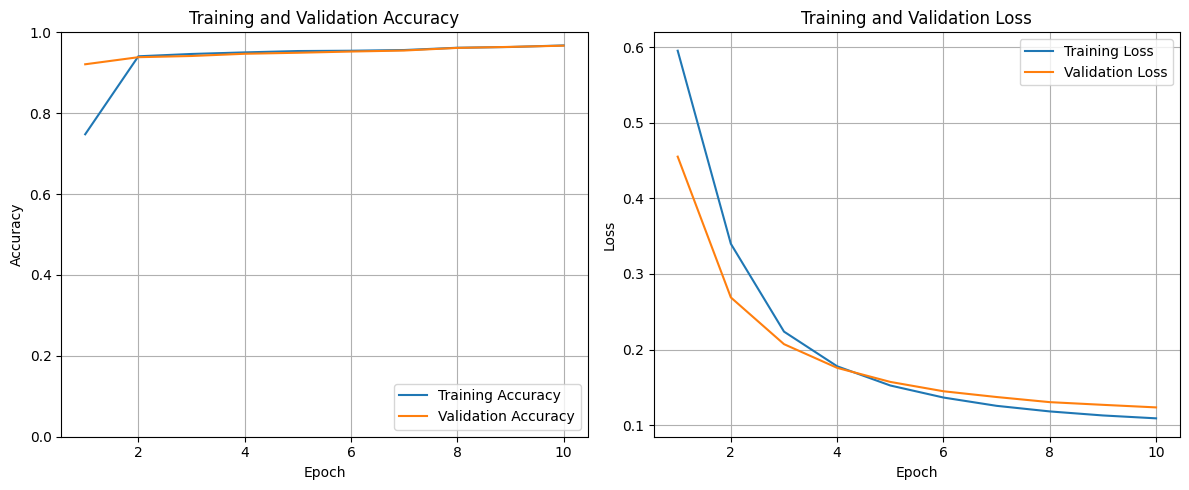


--- Hackathon Project Complete ---


In [ ]:
# --- 0. INSTALL LIBRARIES ---
print("Step 0: Installing libraries...")
!pip install pennylane torchmetrics scikit-learn -q

# --- 0.5. Extract Data if necessary ---
import os
if not os.path.exists('KDDTrain+.txt'):
    print("KDDTrain+.txt not found. Attempting to extract from archive.zip...")
    !unzip -o archive.zip
    # Check again if the file exists after unzipping
    if not os.path.exists('KDDTrain+.txt'):
        print("Warning: KDDTrain+.txt still not found after unzipping. Please ensure it's in archive.zip or upload it.")
    else:
        print("KDDTrain+.txt extracted successfully!")

# --- 1. IMPORTS & CONFIGURATION ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
import pennylane as qml
from pennylane.templates.layers import BasicEntanglerLayers
from pennylane.templates.embeddings import AngleEmbedding

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

print("Libraries imported successfully!")

# --- CONFIGURATION ---
N_QUBITS = 8        # Using 8 qubits/features based on PCA
N_LAYERS = 3        # Number of layers in the QNN
BATCH_SIZE = 32     # Number of data samples to process at once
EPOCHS = 10         # Running for 10 epochs for stable training
LEARNING_RATE = 1e-3
NUM_SAMPLES = 5000  # Taking 5000 normal + 5000 anomaly samples

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 2. DATA LOADING & PREPROCESSING (Real NSL-KDD) ---
print("\n--- Step 2: Loading and Preprocessing REAL NSL-KDD Data ---")

# Define the raw column names
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

def get_nslkdd_data(num_samples=NUM_SAMPLES, n_pca_features=N_QUBITS):
    try:
        df = pd.read_csv('KDDTrain+.txt', header=None, names=column_names)
    except FileNotFoundError:
        raise FileNotFoundError("KDDTrain+.txt not found. Please upload it to Colab.")

    # 1. Preprocessing: Binary Label, Encoding, Scaling
    df['label_binary'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)
    y = df['label_binary'].values

    categorical_cols = ['protocol_type', 'service', 'flag']
    df_features = df.copy()
    for col in categorical_cols:
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col])

    df_features = df_features.drop(columns=['label', 'difficulty', 'label_binary'])
    X = MinMaxScaler().fit_transform(df_features)

    # 2. Balance the dataset
    X_normal = X[y == 0][:num_samples]
    X_anomaly = X[y == 1][:num_samples]

    # Use standard numpy for combining data before torch conversion
    X_subset = np.concatenate((X_normal, X_anomaly))
    y_subset = np.concatenate((np.zeros(len(X_normal)), np.ones(len(X_anomaly))))

    # 3. PCA (Feature Reduction)
    pca = PCA(n_components=n_pca_features)
    X_pca = pca.fit_transform(X_subset)

    return X_pca, y_subset

# Execute data loading and split
X, y = get_nslkdd_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom PyTorch Dataset Class
class NslKddDataset(Dataset):
    def __init__(self, data, labels):
        # Convert NumPy arrays to PyTorch Tensors
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create DataLoaders
train_dataset = NslKddDataset(X_train, y_train)
val_dataset = NslKddDataset(X_val, y_val)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
print(f"Dataset Split: Training {dataset_sizes['train']} | Validation {dataset_sizes['val']}")

# --- 3. HYBRID MODEL DEFINITION (The Stable Architecture) ---

# 3a. Define the Quantum Circuit (QNode)
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
    qml.BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_LAYERS, N_QUBITS)}

# 3b. Define the Hybrid Model Class
class QuantumTelecomClassifier(nn.Module):
    def __init__(self, qlayer):
        super(QuantumTelecomClassifier, self).__init__()

        # 1. Classical "Encoder" Layer (TRAINABLE)
        self.classical_encoder = nn.Linear(N_QUBITS, N_QUBITS)

        # 2. Quantum Classification Layer (TRAINABLE)
        self.qlayer = qlayer

        # 3. Final Classical Output Layer (TRAINABLE)
        self.output_layer = nn.Linear(N_QUBITS, 2)

    def forward(self, x):
        x = x.float()
        x = self.classical_encoder(x) # Encoder (Compresses/Transforms PCA features)
        x = self.qlayer(x)            # Quantum Neural Network
        x = self.output_layer(x)       # Final Classifier
        return x

model = QuantumTelecomClassifier(qml.qnn.TorchLayer(qnn_circuit, weight_shapes)).to(device)

print("\n--- Hybrid Model Defined Successfully ---")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable_params}")


# --- 4. EXECUTE TRAINING AND SHOW RESULTS ---

def train_model(model, criterion, optimizer, num_epochs=EPOCHS):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\n--- Starting Training ---")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # deep copy the model if it's the best one
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print("-" * 20)


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# --- 4a. Setup Optimizer and Loss ---
params_to_train = [param for param in model.parameters() if param.requires_grad]

optimizer = optim.Adam(params_to_train, lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# --- 4b. Run Training ---
model, history = train_model(model, criterion, optimizer)

# --- 4c. Final Evaluation and Plot ---
print("\n--- Final Model Performance (on Validation Set) ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
final_acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"Final Validation Accuracy: {final_acc:.4f}")
print("\nConfusion Matrix (0=Normal, 1=Anomaly):")
print(cm)
print("\nClassification Report:")
print(classification_report(np.array(all_labels), np.array(all_preds), target_names=['Normal (0)', 'Anomaly (1)'], zero_division=0))

# Plot Results
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig("qnn_telecom_results.png") # Save the plot for your submission
plt.show()

print("\n--- Hackathon Project Complete ---")